In [3]:
SAVE_PATH = 'content'

Dont forget to run `conda install ffmpeg` in the terminal after importing everything

In [4]:
# necessary imports

import os
import re
import time
import glob
import torch
import musdb
import random
import librosa
import stempeg
import requests
import warnings
import torchaudio
import torchvision
import numpy as np
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt

from zipfile import ZipFile
from torchsummary import summary
from urllib.request import urlopen
from openunmix.model import OpenUnmix
from torcheval.metrics import R2Score
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchaudio.transforms import Resample, MelSpectrogram

warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# set random seed

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
# setting the GPU

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [7]:
# set the seed to 2024
SEED = 2024
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2024 has been set.
GPU is enabled in this notebook.


In [ ]:
# Load the MUSDB dataset

mus_train = musdb.DB(download=True, subsets='train')
mus_test = musdb.DB(download=True, subsets='test')

In [ ]:
# let's process over a single track

track = mus_train[42]
print(track.name)
print(track.targets.keys())

In [ ]:
# convert the track to mono and display it using a spectrogram

STFT_WINDOW = 2048
STFT_STRIDE = 1024

sample = track.audio.T
sr = track.rate

# converting it to a spectrogram using short time fourier transform
X = librosa.stft(librosa.to_mono(sample),
                 n_fft=STFT_WINDOW,
                 win_length=STFT_WINDOW,
                 hop_length=STFT_STRIDE)

# displaying the spectrogram
librosa.display.specshow(librosa.amplitude_to_db(np.abs(X), ref=np.max),
                         y_axis='log', x_axis='time')

In [11]:
# generating the training and test split using the
# dataloader class from pytorch

# create the spectrogram preprocessing part
class SpecTransform(nn.Module):
    """
    This module creates a spectrogram of each input audio
    """

    def __init__(self, sr=16000, n_fft=2048):
        super().__init__()
        self.n_fft=n_fft
        self.sr=sr
        self.mel = MelSpectrogram(sample_rate=self.sr,
                                  n_fft=self.n_fft, n_mels=512)

    def forward(self, x):
        with torch.no_grad():
            return(self.mel(x))


# create the MUSDB18 torch dataset class
class MUSDBDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            subset='train',
            split='train',
            target='vocals',
            seq_duration=None,
            n_fft=2048,
            sr=44100
    ):
        """
        MUSDB18 Dataset wrapper.
        args:
        subset: either 'test' or 'train'
        split: either 'test' or 'train'
        seq_duration: duration in seconds: float
        """

        self.seq_duration = seq_duration
        self.mus = musdb.DB(
            download=True,
            split=split,
            subsets=subset,
        )
        self.target=target
        self.sr=sr
        self.spec=SpecTransform(n_fft=n_fft)
        self.resample=Resample(new_freq=self.sr)

    def __getitem__(self, index):
        track = self.mus[index]
        track.chunk_start = max(0, random.uniform(0, track.duration - self.seq_duration)) # Prevents rounding errors
        track.chunk_duration = self.seq_duration
        x = track.audio.T
        y = track.targets[self.target].audio.T
        self.resample.orig_freq = track.rate
        signal_x, signal_y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        resampled_x = self.resample(signal_x)
        resampled_y = self.resample(signal_y)
        return self.spec(resampled_x), self.spec(resampled_y)

    def __len__(self):
        return len(self.mus)


In [ ]:
# the above code snippet prepares audio data for training
# from MUSDB tracks, resamples them, and computes their spectrograms
# , these processed data pairs are used during training to train a
# neural network model for vocal separation

# now let's create the dataset for training and testing

BATCH_SIZE = 8
mus_train  = MUSDBDataset(seq_duration=7.0)
mus_test   = MUSDBDataset(subset='train', split='test',
                          seq_duration = 7.0)

In [ ]:
# R2 is a statistical measure that assesses how well a regression model
# fits the observed data.
#   - R2 ranges from 0 to 1 (though it can be negative too)
#   - A value of 1, model perfectly predicts the outcome.
#   - A value of 0, model is as useful as a broken compass.

# building the pytorch model

# 1. Open Unmix - for audio separation

def test_r2(model, device, data_loader):
  """
  Test function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    data_loader: torch.loader
      Test Set

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  metric = R2Score(device=device)
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    metric.update(outputs.flatten(), labels.flatten())
  r2 = metric.compute()
  return r2

def umx_train_loop(model,
                   device,
                   checkpoint_path,
                   train_dataset,
                   epochs=10,
                   batch_size=8,
                   seed=0):
  """
  Training function

  Args:
    model: nn.module
    device: string
    checkpoint_path: string
    train_dataset: torch.loader
    epochs: int
    batch_size: int
    seed: int

  Returns:
    array of loss and accuracy
    Uses RMSE and Adam
  """
  model.to(device)
  model.train()
  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size, shuffle=True)

  loss_fn = nn.MSELoss()
  optimizer = torch.optim.RMSprop(model.parameters(),
                                  lr=0.01, weight_decay=0.02)
  mse_loss = torch.zeros(epochs * len(train_dataset) // batch_size,
                         device=device)
  i = 0
  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(
                        output,
                        target=target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)
        mse_loss[i] = loss.detach()
  return mse_loss

In [21]:
# let's load the model without pretrained weights and train it
umx = OpenUnmix(nb_bins=512) # model initialization

if os.path.exists(f'{SAVE_PATH}/umx_weights'):
    umx = torch.load(f'{SAVE_PATH}/umx_weights')

# training loop
# for _ in range(2):
#     umx_losses = umx_train_loop(umx, device=DEVICE,
#                               checkpoint_path=SAVE_PATH,
#                               train_dataset=mus_train, epochs=8)
#     r2 = test_r2(umx, DEVICE, DataLoader(mus_test, batch_size=BATCH_SIZE))
#     print(f'R2: {r2}')
#     torch.save(umx, f'{SAVE_PATH}/umx_weights')

In [22]:
# summary of the number of parameters and output shapes at each
# level in the model

data_shape = (2, 512, 294)
summary(umx, data_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512]                 524,288
├─BatchNorm1d: 1-2                       [-1, 512]                 1,024
├─LSTM: 1-3                              [-1, 2, 512]              4,730,880
├─Linear: 1-4                            [-1, 512]                 524,288
├─BatchNorm1d: 1-5                       [-1, 512]                 1,024
├─Linear: 1-6                            [-1, 1024]                524,288
├─BatchNorm1d: 1-7                       [-1, 1024]                2,048
Total params: 6,307,840
Trainable params: 6,307,840
Non-trainable params: 0
Total mult-adds (M): 6.29
Input size (MB): 1.15
Forward/backward pass size (MB): 0.04
Params size (MB): 24.06
Estimated Total Size (MB): 25.25


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512]                 524,288
├─BatchNorm1d: 1-2                       [-1, 512]                 1,024
├─LSTM: 1-3                              [-1, 2, 512]              4,730,880
├─Linear: 1-4                            [-1, 512]                 524,288
├─BatchNorm1d: 1-5                       [-1, 512]                 1,024
├─Linear: 1-6                            [-1, 1024]                524,288
├─BatchNorm1d: 1-7                       [-1, 1024]                2,048
Total params: 6,307,840
Trainable params: 6,307,840
Non-trainable params: 0
Total mult-adds (M): 6.29
Input size (MB): 1.15
Forward/backward pass size (MB): 0.04
Params size (MB): 24.06
Estimated Total Size (MB): 25.25

In [ ]:
# X left channel  - original data
x, y = mus_test[0]
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x[0]), ref=np.max),
                         y_axis='log', x_axis='time')

In [ ]:
# Y left channel - original output
librosa.display.specshow(librosa.amplitude_to_db(np.abs(y[0]), ref=np.max),
                         y_axis='log', x_axis='time')

In [ ]:
# Y left channel - predicted output

x = mus_test[0][0].unsqueeze(0).to(DEVICE)
y_pred = umx(x.to(DEVICE)).squeeze().detach().cpu()
np_spec_pred = torch.Tensor.numpy(y_pred)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(np_spec_pred[0]), ref=np.max),
                         y_axis='log', x_axis='time')

In [ ]:
# till here all we did was to train Open Unmix model
# so that it can succesfully separate vocals from songs

# Now we shall use this pretrained model to separate vocals present
# in another dataset, GTZAN specifically.

In [ ]:
# code to download the GTZAN dataset

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# Extract all the contents of zip file in different directory
with ZipFile(fname, 'r') as zipObj:
  zipObj.extractall()

In [ ]:
# This code snippet is creating a mapping between audio files
# and their corresponding genre labels (we are creating X, y).
'''
`.*.` captures any char b/w `'Data/genres_original/'` and the next `'/'`.
The parentheses `(.*.)` group this part of the match.
If successful, it extracts the group containing the genre name.
'''

files_dict = dict()
files = glob.glob('Data/genres_original' + '/**/*.wav', recursive=True)
for file in files:
  regexp = re.match('Data/genres_original/(.*.)/.*.\.wav', file)
  files_dict[file] = regexp.group(1)  # dataset wrapper for GTZAN

In [12]:
# ok, now what we do is apply unmix model on all the GTZAN audio files
# to separate the vocals from the songs, and then we try to perform a
# classification on these new vocals.

class GTZANDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            path,
            seq_duration=None,
            n_fft=2048,
            sr=44100,
            preprocessor=None
    ):
      """GTZAN Dataset wrapper.
      args:
      path: file directory where samples are labeled by genre
      seq_duration: duration in seconds: float
      """
      super().__init__()
      self.seq_duration = seq_duration
      self.files = self._retrieve_paths(path)
      self.sr=sr
      self.spec=SpecTransform(n_fft=n_fft)
      self.resample=Resample(new_freq=self.sr)
      self.preprocessor = preprocessor

    def _retrieve_paths(self, path):
      """
      Retrieves all matching files in path with GTZAN specification.
      It returns a dict {path: label}
      """
      assert os.stat(path) is not False

      files_list = []
      i = 0
      for file in glob.glob(f'{path}/**/*.wav', recursive=True):
        regexp = re.match(f'{path}/(.*.)/.*.\.wav', file)
        files_list.append({'index': i, 'path' : file, 'genre' : regexp.group(1) })
        i += 1

      genres = set()
      for file in files_list:
        genres.add(file['genre'])

      self.genres = {genre : i for i, genre in enumerate(genres)}

      return files_list

    def __getitem__(self, index):
      item = self.files[index]
      track, sr = torchaudio.load(item['path'])
      track_duration = track.shape[1] / sr

      if self.seq_duration is None:
        self.seq_duration = track_duration

      chunk_start = max(0, random.uniform(0, track_duration - self.seq_duration)) # Prevents rounding errors
      track = track[0][int(chunk_start * sr) : int((chunk_start + self.seq_duration) * sr)]
      x = torch.cat((track, track), dim=0)

      y = item['genre']
      self.resample.orig_freq = sr
      resampled_x = self.resample(torch.Tensor(x))
      spec_x = self.spec(resampled_x)

      if self.preprocessor is not None:
        spec_x = self.preprocessor(spec_x.to(DEVICE)).cpu()

      return self._transform_resnet(spec_x), self.genres[y]


    def _transform_resnet(self, x):
      """
    Takes stereo spectogram and adds a third averaged channel to be compatible
    for resnet. Since resnet expects 3-channel images.
    """
      out = torch.cat((x, x[0].unsqueeze(0)), dim=0)
      res_img = F.interpolate(out.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
      return res_img

    def __len__(self):
      return len(self.files)

In [13]:
# processing with Open Unmix

def preprocess_umx(x):
  """
  Takes mono channel spectogram, concatenates it with itself and unsqueezes a
  dimension at the start. Then applies a umx preprocessing.
  """
  umx.eval()
  input = torch.cat((x.unsqueeze(0), x.unsqueeze(0)), dim=0).unsqueeze(0)
  out = umx(input)

  return out.squeeze()

In [14]:
# create the dataset which now only contains vocals

gtzan = GTZANDataset('Data/genres_original',
                     seq_duration=7,
                     preprocessor=preprocess_umx)

print(f'Size of Dataset {len(gtzan)}')

Size of Dataset 999


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


In [ ]:
data = gtzan[0]
print(gtzan.genres)
print(data[0].shape)

In [ ]:
# vocal sample from preprocessed audio in corresponding scaling
# let's see how the mel spectrogram looks

librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(data[0][0].detach().numpy()), ref=np.max),
    y_axis='log', x_axis='time'
    )

#### The entire code is the same as Eder's approach, I am trying resnet 18, with `pretrainedweights=True` and `weights=False` to see which one works.

- resnet 18, finetuning using pre-trained weights.

In [15]:
# now using a pre trained resnet architecture to perform this genre classification
# just training the final layer

resnet_small = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
for param in resnet_small.parameters():
  param.requires_grad = False
    
resnet_small.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# let's add another layer at the end of resnet
# since the number of genres we have are 10

num_genres = 10
num_ftrs = resnet_small.fc.in_features
resnet_small.fc = nn.Linear(num_ftrs, num_genres)

In [24]:
# training loop function for the resnet classifier

def resnet_train(model, device, train_loader, validation_loader, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in tqdm(range(epochs)):
        # train loop
        running_loss = 0.
        correct, total = 0, 0

        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)
        running_loss = 0.
        correct, total = 0, 0

        with torch.no_grad():
            for batch in validation_loader:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                loss = loss_fn(output, labels)
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_loss.append(running_loss / len(validation_loader))
        validation_acc.append(correct / total)

    return train_loss, train_acc, validation_loss, validation_acc

In [25]:
# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir(f'{SAVE_PATH}/checkpoint'):
      os.mkdir(f'{SAVE_PATH}/checkpoint')
  torch.save(state, f'{SAVE_PATH}/checkpoint/{outModelName}.t7')

In [26]:
# create the data loader to load the data for training

gztan_train = DataLoader(gtzan, batch_size=8, shuffle=True,)
train_set, test_set = torch.utils.data.random_split(gtzan, [799, 200])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True)

In [28]:
# training

# empty the cache
torch.cuda.empty_cache()

with torch.backends.cudnn.flags(enabled=False):
    data_shape = [3, 224, 224]
    # resnet_small.fc2.train()
    resnet_losses = resnet_train(
      resnet_small, device=DEVICE,
      train_loader=train_loader,
      validation_loader=test_loader,
      epochs=10)
    torch.save(resnet_small, f'{SAVE_PATH}/checkpoint/resnet_small.t7')

100%|██████████| 10/10 [2:06:38<00:00, 759.83s/it] 


RuntimeError: Parent directory content/checkpoint does not exist.

In [29]:
print(resnet_losses)
torch.save(resnet_small, f'{SAVE_PATH}/resnet_small.t7')

([1.8912536001205444, 1.8666752541065217, 1.8702108311653136, 1.8722581481933593, 1.851194853782654, 1.8437691640853882, 1.8409796416759492, 1.8321735227108003, 1.8129220747947692, 1.8276050996780395], [0.3454317897371715, 0.35168961201501875, 0.344180225281602, 0.37546933667083854, 0.3454317897371715, 0.360450563204005, 0.360450563204005, 0.3642052565707134, 0.37296620775969963, 0.36545682102628285], [1.8844707250595092, 1.9442346382141114, 1.9011940383911132, 1.9410908937454223, 1.8726764345169067, 1.9577872085571288, 1.8948755359649658, 1.8918895387649537, 1.8825101995468139, 1.9634679079055786], [0.385, 0.315, 0.38, 0.325, 0.35, 0.33, 0.395, 0.37, 0.36, 0.33])


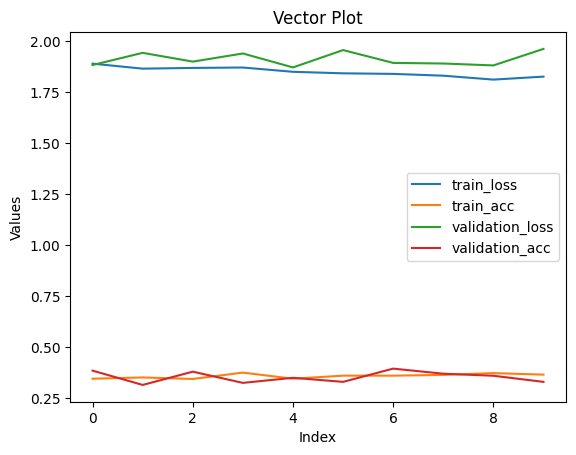

In [32]:
# let's plot these values
train_loss, train_acc, validation_loss, validation_acc = resnet_losses
# Example vectors (replace with your actual data)
train_loss = np.array(train_loss)
train_acc = np.array(train_acc)
validation_loss = np.array(validation_loss)
validation_acc = np.array(validation_acc)

# Create an array for the x-axis (indices)
x = np.arange(10)

# Plot the vector
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, validation_loss, label='validation_loss')
plt.plot(x, validation_acc, label='validation_acc')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Vector Plot')

# Add legend
plt.legend()

# Apply the "solarize" style
plt.style.use('Solarize_Light2')

# Show the plot
plt.show()


- training resnet from scratch

[x] Not doing.

In [ ]:
# using just the architecture and training it from scratch

resnet_small_v1 = torchvision.models.resnet18(weights=None)
resnet_small_v1.to(DEVICE)
summary(resnet_small, (3, 224, 224))

In [ ]:
resnet_small_v1.fc = nn.Linear(num_ftrs, num_genres)

In [ ]:
# training loop for training from scratch

with torch.backends.cudnn.flags(enabled=False):
  data_shape = [3, 224, 224]
  for _ in range(10):
    # resnet_small.fc2.train()
    resnet_losses = resnet_train(
      resnet_small_v1, device=DEVICE,
      train_loader=train_loader,
      validation_loader=test_loader,
      epochs=10)
    torch.save(resnet_small_v1, f'{SAVE_PATH}/checkpoint/resnet_small_v1.t7')

In [ ]:
# Now after training this on the outputs of open unmix, I don't remember what to do next
# so after comparing the results, seeing which architecture might be better, we might use that
# architecture for the next stage of fine tuning

### What did the resnet learn if it did learn anything?

Let's find out what the code learn's

In [30]:
def layer_visualization(model):
  with torch.no_grad():
    params = list(model.parameters())
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    filters = []
    for filter_index in range(params[0].shape[0]):
      row_index = filter_index // 8
      col_index = filter_index % 8

      filter = params[0][filter_index,:,:,:]
      filter_image = filter.permute(1, 2, 0).cpu()
      scale = np.abs(filter_image).max()
      scaled_image = filter_image / (2 * scale) + 0.5
      filters.append(scaled_image.cpu())
      axs[row_index, col_index].imshow(scaled_image.cpu())
      axs[row_index, col_index].axis('off')
    plt.show()

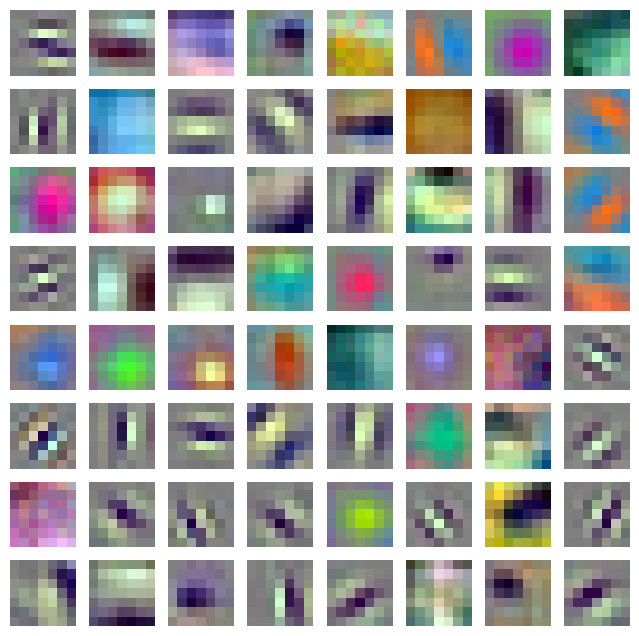

In [31]:
layer_visualization(resnet_small)

In [ ]:
# layer_visualization(resnet_small_v1)

### Next step in finetuning.